# Response to Byass

In [1]:
from __future__ import division
import urllib2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
def download_ghdx_data():
    """Download PHMRC data and codebook from GHDx

    Returns:
        codebook (dataframe)
        adult_data (dataframe)
        child_data (dataframe)
        neonate_data (dataframe)
    """
    out = []
    ghdx_url = ('http://ghdx.healthdata.org/sites/default/files/'
                'record-attached-files')
    GHDX_CODEBOOK = 'IHME_PHMRC_VA_DATA_CODEBOOK_Y2013M09D11_0.csv'
    GHDX_FILENAME = 'IHME_PHMRC_VA_DATA_{}_Y2013M09D11_0.csv'


    # The codebook is an excel file instead of a csv on the GHDx
    url = '{ghdx}/{cb}.xlsx'.format(ghdx=ghdx_url, cb=GHDX_CODEBOOK[:-4])
    response = urllib2.urlopen(url)
    xls = pd.ExcelFile(response)
    codebook = xls.parse(xls.sheet_names[0])
    out.append(codebook)

    for module in ['ADULT', 'CHILD', 'NEONATE']:
        f = GHDX_FILENAME.format(module.upper())
        url = '{ghdx}/{f}'.format(ghdx=ghdx_url, f=f)
        response = urllib2.urlopen(url)
        df = pd.read_csv(response)
        out.append(df)

    return tuple(out)

In [3]:
# Load the data
codebook, adult, child, neonate = download_ghdx_data()

# Combine the three modules into one dataframe
df = pd.concat([adult, child, neonate])

# We will lookup variables by their name
codebook = codebook.set_index('variable')

# Create a unique id across modules
df = df.set_index(df.module + df.newid.astype(str))

C:\Users\josephj7\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (18,29,38,41,60,96) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\josephj7\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (26,60,84,164) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\josephj7\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (23,60,62,65,82) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Invalid Age/Sex Data
Dates of birth and death were
recorded in two duplicate sets of variables (g1_01/6 and
g5_01/3) as well as duplicate variables for age at death
(g1_07 and g5_04). For some individuals there were inconsistencies
between these age-related variables, and
cases were dropped where these inconsistencies resulted
in ambiguities between WHO 2012 age groups. Overall,
494 cases (3.9%) in the PHMRC dataset had no valid age
or sex recorded and were excluded from InterVA-4 processing.

##### Response:
The claim that 494 had no valid age or sex recorded is completely
wrong. Even if we interpret this as 494 observations were missing
either valid age data or valid sex data the claim is still
completely wrong. What (I think) Byass is actually claiming is:
"There were 494 observations where there was at least some missing
data or valid data which was not consistent and it was not possible
to unambiguously assign the record to an age-sex bin."

###### Sex

In [4]:
codebook.loc[codebook.question.str.lower().str.contains('sex')]

,question,module,health_care_experience,coding
variable,,,,
g1_05,Sex of deceased,General,0,"1 ""Male"" 2 ""Female"" 8 ""Refused to Answer"" 9 ""D..."
g4_02,What is the sex of the respondent?,General,0,"1 ""Male"" 2 ""Female"" 8 ""Refused to Answer"" 9 ""D..."
g5_02,What was the sex of the deceased?,General,0,"1 ""Male"" 2 ""Female"" 8 ""Refused to Answer"" 9 ""D..."
c1_09,What was the sex of the deceased?,Child,0,"1 ""Male"" 2 ""Female"" 8 ""Refused to Answer"" 9 ""D..."


In [5]:
df.g5_02.value_counts(dropna=False)

Male          6813
Female        5695
NaN             21
Don't Know       1
Name: g5_02, dtype: int64

In [6]:
# Missingness from 'g5_02'
missing_sex1 = df.g5_02.isnull() | (df.g5_02 == "Don't Know")
missing_sex1.sum()

22

In [7]:
df.g1_05.value_counts(dropna=False)

Male          6815
Female        5696
NaN             18
Don't Know       1
Name: g1_05, dtype: int64

In [8]:
# Missingness from 'g1_05'
missing_sex2 = df.g1_05.isnull() | (df.g1_05 == "Don't Know")
missing_sex2.sum()

19

In [9]:
# Actually missing
missing_sex = missing_sex1 & missing_sex2
missing_sex.sum()

4

In [10]:
# All observations with either sex variable listed as
# missing or don't know
pd.crosstab(df.loc[(missing_sex1 | missing_sex2), 'g1_05'].fillna('Missing'), 
            df.loc[(missing_sex1 | missing_sex2), 'g5_02'].fillna('Missing'),
            margins=True)

g5_02,Don't Know,Female,Male,Missing,All
g1_05,,,,,
Don't Know,1,0,0,0,1
Female,0,0,0,6,6
Male,0,0,0,12,12
Missing,0,5,10,3,18
All,1,5,10,21,37


In [11]:
# Observations where the two sex variables do not match
# Only 4 observations have both male and female listed
# Most of the mismatch is due to missingness
pd.crosstab(df.loc[(df.g1_05 != df.g5_02), 'g1_05'].fillna('Missing'), 
            df.loc[(df.g1_05 != df.g5_02), 'g5_02'].fillna('Missing'),
            margins=True)

g5_02,Female,Male,Missing,All
g1_05,,,,
Female,0,2,6,8
Male,2,0,12,14
Missing,5,10,3,18
All,7,12,21,40


###### Age

In [12]:
# The two sets of age variable
age_vars1 = ['g5_04a', 'g5_04b', 'g5_04c']
age_vars2 = ['g1_07a', 'g1_07b', 'g1_07c']

# The two sets of date variables
dates1 = ['g1_01d', 'g1_01m', 'g1_01y', 'g1_06d', 'g1_06m', 'g1_06y']
dates2 = ['g5_01d', 'g5_01m', 'g5_01y', 'g5_03d', 'g5_03m', 'g5_03y']

In [13]:
codebook.loc[age_vars1 + age_vars2]

,question,module,health_care_experience,coding
variable,,,,
g5_04a,What was the last known age of the deceased? [...,General,0,"999 ""Don't Know"""
g5_04b,What was the last known age of the deceased? [...,General,0,"99 ""Don't Know"""
g5_04c,What was the last known age of the deceased? [...,General,0,"99 ""Don't Know"""
g1_07a,Last known age of the deceased [years],General,0,"999 ""Don't Know"""
g1_07b,Last known age of the deceased [months],General,0,"99 ""Don't Know"""
g1_07c,Last known age of the deceased [days],General,0,"99 ""Don't Know"""


In [14]:
codebook.loc[dates1 + dates2]

,question,module,health_care_experience,coding
variable,,,,
g1_01d,Date of birth [day],General,0,"99 ""Don't Know"""
g1_01m,Date of birth [month],General,0,"1 ""January"" 2 ""February"" 3 ""March"" 4 ""April"" 5..."
g1_01y,Date of birth [year],General,0,"9999 ""Don't Know"""
g1_06d,Date of death [day],General,0,"99 ""Don't Know"""
g1_06m,Date of death [month],General,0,"1 ""January"" 2 ""February"" 3 ""March"" 4 ""April"" 5..."
g1_06y,Date of death [year],General,0,"9999 ""Don't Know"""
g5_01d,When was the deceased born? [day],General,0,"99 ""Don't Know"""
g5_01m,When was the deceased born? [month],General,0,"1 ""January"" 2 ""February"" 3 ""March"" 4 ""April"" 5..."
g5_01y,When was the deceased born? [year],General,0,"9999 ""Don't Know"""


In [15]:
def calc_missing_age(series, age_vars):
    ages = pd.to_numeric(series.loc[age_vars], errors='coerce')
    return not ages.notnull().any()

In [16]:
def calc_agedays(series, age_vars):
    """Calculate age (in days) from three age vars"""
    # Transform "Don't Know" into missing
    series = pd.to_numeric(series.loc[age_vars], errors='coerce')
    
    if series.isnull().all():
        # There is no age data
        return np.nan
    else:
        # There is at least one non-missing age value
        years, months, days = series.fillna(0)
        return years * 365 + months * 30 + days

In [17]:
def calc_agedays_from_dates(series, date_vars):
    series = series.replace({"Don't Know": np.nan})
    birthdate = series.loc[date_vars[:3]]
    deathdate = series.loc[date_vars[3:]]
    
    if birthdate.isnull().any() or deathdate.isnull().any():
        return np.nan
    
    try:
        birthday = pd.to_datetime('{} {} {}'.format(int(birthdate[0]), birthdate[1], int(birthdate[2])))
        deathday = pd.to_datetime('{} {} {}'.format(int(deathdate[0]), deathdate[1], int(deathdate[2])))
        agedays = (deathday - birthday).days
        if agedays < 0:
            return np.nan
        else:
            return agedays
    except ValueError:
        return np.nan

In [18]:
def calc_age_group(agedays):
    """Return the broad age group from age in days"""
    if pd.isnull(agedays):
        return np.nan
    elif agedays <= 28:
        return 'neonate'
    elif agedays < 15 * 365:
        return 'child'
    else:
        return 'adult'


In [19]:
def calc_age_group6(agedays):
    if pd.isnull(agedays):
        return np.nan
    elif agedays <= 28:
        return 'neonate'
    elif agedays < 365:
        return 'infant'
    elif agedays < 5 * 365:
        return 'under5'
    elif agedays < 15 * 365:
        return 'child'
    elif agedays < 50 * 365:
        return 'adult'
    elif agedays < 65 * 365:
        return 'midage'
    else:
        return 'elder'

In [20]:
def calc_inconsistent_age(series, vars1, vars2):
    age1 = calc_agedays(series, vars1)
    age2 = calc_agedays(series, vars2)
    return age1 != age2

In [21]:
def calc_inconsistent_age_group(series, vars1, vars2):
    age1 = calc_age_group(series, vars1)
    age2 = calc_age_group(series, vars2)
    return age1 != age2

In [22]:
def calc_inconsistent_age_group6(series, vars1, vars2):
    age1 = calc_age_group6(series, vars1)
    age2 = calc_age_group6(series, vars2)
    return age1 != age2

In [23]:
def calc_years_from_days(agedays):
    return agedays/365

In [24]:
# Calculate age in days from both sets age variables
# and both sets of date variables
ages = pd.concat([
        df.apply(calc_agedays, axis=1, args=(age_vars1,)),
        df.apply(calc_agedays, axis=1, args=(age_vars2,)),
        df.apply(calc_agedays_from_dates, axis=1, args=(dates1,)),
        df.apply(calc_agedays_from_dates, axis=1, args=(dates2,)),
    ], axis=1)
ages.columns = ['age_g5', 'age_g1', 'dates_g1', 'dates_g5']

# Calculate age in years from the four previous age in days
ages['age_g5y'] = ages['age_g5'].map(calc_years_from_days)
ages['age_g1y'] = ages['age_g1'].map(calc_years_from_days)
ages['dates_g1y'] = ages['dates_g1'].map(calc_years_from_days)
ages['dates_g5y'] = ages['dates_g5'].map(calc_years_from_days)

# Calculate both broad and specific age groups for each age
ages['age_g5_3'] = ages['age_g5'].map(calc_age_group)
ages['age_g5_6'] = ages['age_g5'].map(calc_age_group6)

ages['age_g1_3'] = ages['age_g1'].map(calc_age_group)
ages['age_g1_6'] = ages['age_g1'].map(calc_age_group6)

ages['dates_g1_3'] = ages['dates_g1'].map(calc_age_group)
ages['dates_g1_6'] = ages['dates_g1'].map(calc_age_group6)

ages['dates_g5_3'] = ages['dates_g5'].map(calc_age_group)
ages['dates_g5_6'] = ages['dates_g5'].map(calc_age_group6)

In [25]:
ages[['age_g5', 'age_g1', 'dates_g1', 'dates_g5']].isnull().all(1).sum()

124

In [26]:
inconsistent6 = ages[['age_g5_6', 'age_g1_6', 'dates_g1_6', 'dates_g5_6']].apply(lambda x: len(x.dropna().unique()) != 1, axis=1)
inconsistent6.sum()

522

In [27]:
inconsistent3 = ages[['age_g5_3', 'age_g1_3', 'dates_g1_3', 'dates_g5_3']].apply(lambda x: len(x.dropna().unique()) != 1, axis=1)
inconsistent3.sum()

210

In [28]:
(inconsistent6 | (missing_sex1 & missing_sex2)).sum()

526

In [29]:
(ages[['age_g5y', 'age_g1y', 'dates_g1y', 'dates_g5y']] < 0).any(1).sum()

0

In [30]:
ages.loc[inconsistent6 & ages.index.str.startswith('Neonate'), 
         ['age_g5', 'age_g1', 'dates_g1', 'dates_g5', 'age_g5_6', 'age_g1_6', 'dates_g1_6', 'dates_g5_6']].fillna('')

,age_g5,age_g1,dates_g1,dates_g5,age_g5_6,age_g1_6,dates_g1_6,dates_g5_6
Neonate53,0,0,181,0,neonate,neonate,infant,neonate
Neonate65,0,0,1,90,neonate,neonate,neonate,infant
Neonate239,8,2920,8,8,neonate,child,neonate,neonate
Neonate347,8,365,375,8,neonate,under5,under5,neonate
Neonate361,23,23,30,30,neonate,neonate,infant,infant
Neonate407,7,7,7,37,neonate,neonate,neonate,infant
Neonate505,8,,311,8,neonate,,infant,neonate
Neonate545,1825,5,5,5,child,neonate,neonate,neonate
Neonate590,3,3,2,125,neonate,neonate,neonate,infant
Neonate841,5,1825,5,5,neonate,child,neonate,neonate


In [31]:
ages.loc[inconsistent6 & ages.index.str.startswith('Child'), 
         ['age_g5y', 'age_g1y', 'dates_g1y', 'dates_g5y', 'age_g5_6', 'age_g1_6', 'dates_g1_6', 'dates_g5_6']].fillna('')

,age_g5y,age_g1y,dates_g1y,dates_g5y,age_g5_6,age_g1_6,dates_g1_6,dates_g5_6
Child5,6,6,0.136986,0.136986,child,child,infant,infant
Child64,0.821918,10,0.863014,0.863014,infant,child,infant,infant
Child70,0.739726,9,0.780822,0.780822,infant,child,infant,infant
Child113,0.493151,0.493151,,1.56438,infant,infant,,under5
Child143,1,1,1.1726,0.169863,under5,under5,under5,infant
Child163,1,1,0.857534,0.857534,under5,under5,infant,infant
Child193,1,1,0.956164,0.956164,under5,under5,infant,infant
Child194,11,11,0.090411,11.6795,child,child,infant,child
Child196,0.0821918,0.0821918,0.0328767,0.0328767,infant,infant,neonate,neonate
Child201,0.575342,7,0.583562,0.583562,infant,child,infant,infant


In [32]:
missing_age1 = ages.age_g5y.isnull()
missing_age2 = ages.age_g1y.isnull()
missing_age3 = ages.dates_g1y.isnull()
missing_age4 = ages.dates_g5y.isnull()

In [33]:
missing_age1.sum()

141

In [34]:
missing_age2.sum()

398

In [35]:
missing_age3.sum()

5282

In [36]:
missing_age4.sum()

3746

In [37]:
(missing_age1 & missing_age2).sum()

124

In [38]:
(ages.age_g5y != ages.age_g1y).sum()

2219

In [39]:
(((ages.age_g5_6 != ages.age_g1_6) & ages.age_g5_6.notnull() & ages.age_g1_6.notnull()) | 
 (missing_age1 & missing_age2) |
 (missing_sex1 | missing_sex2)).sum()

408

In [40]:
(((ages.age_g5_6 != ages.age_g1_6) & ages.age_g5_6.notnull() & ages.age_g1_6.notnull()) | 
 (missing_age1 & missing_age2) |
 (missing_sex1 & missing_sex2)).sum()

380

In [41]:
(missing_age1 | missing_age2).sum()

415

In [42]:
inconsistent_age = df.apply(calc_inconsistent_age, axis=1, args=(age_vars1, age_vars2))
inconsistent_age.sum()

2219

## Contradictory Pregnancy Status
Deaths among women aged 12 to 49 accounted for
1,884/11,984 (15.7%) of the cases, and 458 (24.3%) of these
deaths were classified as ‘Maternal’ in the PHMRC dataset.
However, 17/1,884 (0.9%) of these deaths had contradictory
pregnancy status information in the VA data (for example,
both pregnant and recently delivered at death).

#### Response:
Byass's concern about 17 observations with contradictory pregnancy status refer to observations where the respondent said 'Yes' to `a3_10`: 'Was [name] pregnant at the time of death?' and also said 'Yes' to `a3_18`: 'Did she die within 6 weeks of childbirth?'. Byass clearly interpretted this question as with six weeks AFTER childbirth. Some respondents clearly interpreted this question as "Would she have given birth in the next six weeks if she had not died?"

This can be shown by by examining the question `a3_11`: 'For how many months was she pregnant?' The survey question asked in units of months, although the database stored the results in days. (All the responses are multiples of 30.) It's valid to assume that seven months pregnant can be interpretted as AT LEAST seven months. 15 of the 17 observations were at least seven months pregnant. It was reasonable and consistent for the respondent to say the decedent was within six weeks of childbirth.

In [46]:
codebook.loc[['a3_07','a3_08a','a3_08b','a3_10','a3_11a','a3_11b', 'a3_12', 'a3_15', 'a3_17', 'a3_18']].fillna('')

,question,module,health_care_experience,coding
variable,,,,
a3_07,At the time of death was her period overdue?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_08a,For how many weeks was her period overdue? [sp...,Adult,0,"1 ""Years"" 2 ""Months"" 3 ""Weeks"" 4 ""Days"" 5 ""Hou..."
a3_08b,For how many weeks was her period overdue?,Adult,0,
a3_10,Was [name] pregnant at the time of death?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_11a,For how many months was she pregnant? [specify...,Adult,0,"1 ""Years"" 2 ""Months"" 3 ""Weeks"" 4 ""Days"" 5 ""Hou..."
a3_11b,For how many months was she pregnant?,Adult,0,
a3_12,Did [name] die during an abortion?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_15,Did she die during labor or delivery?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_17,Did she die within 6 weeks after having an abo...,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."


In [47]:
# Byass sites 458 maternal deaths. He's probably dropped
# observations without valid age/sex data
(df.gs_text34 == 'Maternal').sum()

468

In [48]:
# I'm not sure what age/sex variable he's using and
# which observations he's dropped
((df.g5_02 == 'Female') &
 (pd.to_numeric(df.g5_04a, errors='coerce') >= 12) &
 (pd.to_numeric(df.g5_04a, errors='coerce') <= 49)).sum()

1923

In [49]:
# These are the 17 observations Byass claims have contradictory
# pregnancy status
preg_and_6_weeks = (df.a3_10 == 'Yes') & (df.a3_18 == 'Yes')
preg_and_6_weeks.sum()

17

In [50]:
df.loc[preg_and_6_weeks, 'a3_11'].value_counts().sort_index()

180.0    2
210.0    5
240.0    2
270.0    8
Name: a3_11, dtype: int64

## Unreported Pregnancy Status
Of the 458
PHMRC ‘Maternal’ deaths, 90 (19.7%) were not reported in
the VA interview to have been pregnant at or within six
weeks of death.

##### Response:
These 90 observations where the gold standard cause is 
'Maternal', and the respondent did not respond 'Yes' 
to any of the following questions:
* a3_10: Was [name] pregnant at the time of death?
* a3_17: Did she die within 6 weeks after having an abortion?
* a3_18: Did she die within 6 weeks of childbirth?

Of these one respondent, a friend (not a family member) 
did not know if the decedent was pregnant. This death 
is listed as "Other Pregnancy-Related Death".

Of the 90 observations, 8 (8.9%) said the decedent's 
period was overdue, and 5 (5.6%) either didn't know or 
refused to answer whether the decedents period was 
overdue. 37 of the 90 (41.1%) endorsed either 
intermenstrual vaginal bleeding or excessive vaginal 
bleeding within a week prior to death. An additional 
3 observations would not rule out sharp belly pain 
just before death ('Yes' or "Don't Know").

This is real data. Family and friends may not know if
the woman is pregnant.

In [51]:
unreported_pregnancy_vars = ['a3_05', 'a3_06', 'a3_07', 'a3_09', 'a3_10', 'a3_17', 'a3_18']
codebook.loc[unreported_pregnancy_vars]

,question,module,health_care_experience,coding
variable,,,,
a3_05,Did [name] have vaginal bleeding other than he...,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_06,Was there excessive vaginal bleeding in the we...,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_07,At the time of death was her period overdue?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_09,Did [name] have a sharp pain in the belly shor...,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_10,Was [name] pregnant at the time of death?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_17,Did she die within 6 weeks after having an abo...,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a3_18,Did she die within 6 weeks of childbirth?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."


In [52]:
# Byass has properly dropped some observations 
# that didn't have enough age/sex data
(df.gs_text34 == 'Maternal').sum()

468

In [53]:
# These are the 90 observation to which Byass is refering
unreported_maternal = ((df.gs_text34 == 'Maternal') & 
                       (df.a3_10 != 'Yes') & 
                       (df.a3_17 != 'Yes') & 
                       (df.a3_18 != 'Yes'))
unreported_maternal.sum()

90

In [54]:
df.loc[unreported_maternal, 'a3_10'].value_counts()

No            89
Don't Know     1
Name: a3_10, dtype: int64

In [55]:
df.loc[unreported_maternal & (df.a3_10 == "Don't Know"), ['gs_text55', 'g4_03a', 'g4_03b', 'a3_07', 'a3_10']]

,gs_text55,g4_03a,g4_03b,a3_07,a3_10
Adult3166,Other Pregnancy-Related Deaths,Other Female,FRIEND,Don't Know,Don't Know


In [56]:
df.loc[unreported_maternal, 'a3_17'].value_counts()

No    90
Name: a3_17, dtype: int64

In [57]:
df.loc[unreported_maternal, 'a3_18'].value_counts()

No    90
Name: a3_18, dtype: int64

In [58]:
df.loc[unreported_maternal, 'a3_19'].value_counts()

No    90
Name: a3_19, dtype: int64

In [59]:
df.loc[unreported_maternal, 'a3_20'].value_counts()

No    90
Name: a3_20, dtype: int64

In [60]:
df.loc[unreported_maternal, 'a3_05'].value_counts()

No            62
Yes           26
Don't Know     2
Name: a3_05, dtype: int64

In [61]:
df.loc[unreported_maternal, 'a3_06'].value_counts()

No            61
Yes           23
Don't Know     6
Name: a3_06, dtype: int64

In [62]:
hemorrage_signs = ((df.loc[unreported_maternal, 'a3_05'] == 'Yes') | 
                   (df.loc[unreported_maternal, 'a3_06'] == 'Yes'))
hemorrage_signs.sum()

37

In [63]:
any_maternal_signs = hemorrage_signs | (df.loc[unreported_maternal, 'a3_09'] != 'No')
any_maternal_signs.sum()

40

In [64]:
df.loc[unreported_maternal].loc[hemorrage_signs, 'gs_text55'].value_counts()

Hemorrhage                        16
Other Pregnancy-Related Deaths     9
Anemia                             5
Hypertensive Disorder              5
Sepsis                             2
Name: gs_text55, dtype: int64

In [65]:
df.loc[unreported_maternal, 'a3_07'].value_counts()

No                   77
Yes                   8
Don't Know            4
Refused to Answer     1
Name: a3_07, dtype: int64

In [66]:
df.loc[unreported_maternal & (df.a3_07 != 'No'), ['g4_03a',  'g4_03b', 'a3_07', 'a3_10']]

,g4_03a,g4_03b,a3_07,a3_10
Adult55,Mother,NaN,Yes,No
Adult1096,Husband,NaN,Yes,No
Adult1195,Husband,NaN,Yes,No
Adult1295,Sister,NaN,Yes,No
Adult2318,Mother,NaN,Yes,No
Adult2337,Other Male,Neighbour,Don't Know,No
Adult3166,Other Female,FRIEND,Don't Know,Don't Know
Adult4787,Mother,NaN,Yes,No
Adult5172,Other Female,STEP-MOTHER,Yes,No
Adult5890,Sister,NaN,Don't Know,No


In [67]:
df.loc[unreported_maternal, 'a3_09'].value_counts()

No            87
Don't Know     2
Yes            1
Name: a3_09, dtype: int64

In [68]:
df.loc[unreported_maternal, 'gs_text55'].value_counts()

Hemorrhage                        28
Other Pregnancy-Related Deaths    26
Hypertensive Disorder             14
Sepsis                            11
Anemia                             8
Obstructed Labor                   3
Name: gs_text55, dtype: int64

In [69]:
df.loc[unreported_maternal, 'g4_03a'].value_counts()

Husband            27
Other Female       17
Mother             16
Sister             12
Other Male          7
Aunt                5
Brother             3
Birth Attendant     1
Wife                1
Grandmother         1
Name: g4_03a, dtype: int64

## Stillbirths with symptoms
In 147/1,001 (14.7%) deaths which were recorded as stillbirths in hospitals, the circumstances were recorded as neonatal deaths in VA interviews, mostly during the first day of life. However, the symptoms reported in many of these discrepant cases were contradictory, leading to many being categorized as indeterminate in cause by InterVA-4.

In [70]:
neonate_symptoms = ['c1_12', 'c1_13', 'c1_14',
                    'c3_04', 'c3_05', 'c3_07', 'c3_09', 'c3_11', 'c3_13',
                    'c3_16', 'c3_17', 'c3_20', 'c3_23', 'c3_24', 'c3_25',
                    'c3_26', 'c3_29', 'c3_32', 'c3_33', 'c3_34', 'c3_35',
                    'c3_36', 'c3_37', 'c3_38', 'c3_39', 'c3_40', 'c3_41',
                    'c3_42', 'c3_44', 'c3_46', 'c3_47', 'c3_48', 'c3_49']

In [71]:
codebook.loc[neonate_symptoms]

,question,module,health_care_experience,coding
variable,,,,
c1_12,Did the baby ever cry?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c1_13,Did the baby ever move?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c1_14,Did the baby ever breathe?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_04,Did the baby breathe immediately after birth?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_05,Did the baby have difficulty breathing?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_07,Did the baby cry immediately after birth?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_09,Did the baby stop being able to cry?,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_11,Was the baby able to suckle in a normal way du...,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
c3_13,Did the baby stop being able to suckle in a no...,Child,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."


In [72]:
len(neonate_symptoms)

33

In [73]:
stillbirth = df.gs_text34 == 'Stillbirth'
df.loc[stillbirth].c1_11.value_counts()

Dead                 913
Alive                 84
Don't Know             7
Refused to Answer      1
Name: c1_11, dtype: int64

In [75]:
stillbirth_symptoms = df.loc[stillbirth, neonate_symptoms].applymap(lambda x: True if x == "Yes" else False)
stillbirth_symptoms.any(1).sum()

81

In [76]:
pd.crosstab(stillbirth_symptoms.any(1), df.loc[stillbirth, 'c1_11'])

c1_11,Alive,Dead,Don't Know,Refused to Answer
row_0,,,,
False,7,910,6,1
True,77,3,1,0


In [77]:
stillbirth_symptoms.sum()

c1_12    36
c1_13    61
c1_14    72
c3_04    69
c3_05    35
c3_07    34
c3_09    26
c3_11     3
c3_13     3
c3_16     1
c3_17    46
c3_20     6
c3_23     3
c3_24     6
c3_25     0
c3_26     5
c3_29    10
c3_32    16
c3_33    11
c3_34     2
c3_35     1
c3_36     2
c3_37     0
c3_38     0
c3_39     1
c3_40     2
c3_41     2
c3_42     2
c3_44     0
c3_46     1
c3_47    21
c3_48     2
c3_49    25
dtype: int64

In [78]:
df.loc[stillbirth & stillbirth_symptoms.any(1), 'site'].value_counts()

Dar       40
Pemba     20
Mexico     8
AP         7
Bohol      6
Name: site, dtype: int64

## High Rates of Respiratory Symptoms
A high proportion of cases (7,898/11,984; 65.9%) were reported as having respiratory symptoms in the VA interviews, although 2,134/11,984 (17.8%) had respiratory-related PHMRC causes of death assigned.

In [79]:
resp_cod = ['Asthma', 'Birth asphyxia', 'COPD', 'Lung Cancer', 'Pneumonia', 'TB']
df.loc[df.gs_text34.isin(resp_cod)].groupby('module').size()

module
Adult      1140
Child       532
Neonate     545
dtype: int64

In [80]:
resp_symptoms = pd.DataFrame(index=df.index)
resp_symptoms['module'] = df.module
resp_symptoms['cause'] = df.gs_text34.map(lambda x: 'resp' if x in resp_cod else 'other')
resp_symptoms['rapid_breathing'] = (df.a2_40 == 'Yes') | (df.c3_20 == 'Yes')
resp_symptoms['on_exertion'] = (df.a2_39_1 == 'Walking/Exertion') | (df.a2_39_2 == 'Walking/Exertion')
resp_symptoms['lying_down'] = (df.a2_39_1 == 'Lying') | (df.a2_39_2 == 'Lying')
resp_symptoms['indrawing'] = (df.c3_23 == 'Yes') | (df.c4_20 == 'Yes')
resp_symptoms['wheezing'] = (df.a2_42 == 'Yes') | (df.c4_23 == 'Yes') | (df.c4_23 == 'Yes') | (df.c3_24)

In [81]:
resp_symptoms.groupby(['module', 'cause']).sum().stack().unstack(1).sortlevel(0,1,False).unstack(0)

cause             resp                  other               
module           Adult  Child Neonate   Adult  Child Neonate
rapid_breathing  608.0    0.0   123.0  2419.0    0.0   285.0
on_exertion      103.0    0.0     0.0   351.0    0.0     0.0
lying_down       340.0    0.0     0.0  1729.0    0.0     0.0
indrawing          0.0  274.0   102.0     0.0  359.0   269.0
wheezing         345.0  164.0   545.0  1077.0  275.0  2080.0

In [82]:
resp_symptoms.cause.value_counts()

other    10313
resp      2217
Name: cause, dtype: int64

## Preterm
Nevertheless, there are some differences both of principle
and detail that cannot be totally reconciled between the
PHMRC and WHO 2012 approaches. The PHMRC study
set out to rigorously define causes of death, but this involved
imposing some hierarchies which may not be
universally recognized and are not always consistent with
ICD-10 coding. For example, prematurity as cause of death
can be applied according to the PHMRC definitions if a
baby is born at <33 weeks gestational age and experienced
‘death from another medically documented neonatal
condition’ irrespective of that condition [7]. This differs
appreciably from ICD-10 coding: ‘The mode of death, e.g.
heart failure, asphyxia or anoxia, should not be entered…
[as the most important cause] …unless it was the only
fetal or infant condition known. This also holds true for
prematurity’. [18]. As can be seen from the PHMRC causes
of death in Figure 1, prematurity is consequently the dominant
component of mortality throughout the neonatal
period. InterVA-4, on the other hand, ascribes more of
these later neonatal deaths among premature babies to
infectious causes, based on their subsequently reported
symptoms. Neither of these two approaches is necessarily
right or wrong, and both may actually be different views
of the same reality; but the differences are very important
in statistical descriptions of neonatal mortality and in
assessing the comparability of different methods of cause
of death ascertainment.

##### Response:
Here's a slightly different mapping from the detailed list to
a the categories Byass reports in Figure 1. Preterm with infections
have been categorized as infections instead of preterm which
starts to show the pattern Byass found with Interva, though not
too strongly.

In [83]:
def calc_neonate_ages(series, age_vars):
    agedays = calc_agedays(series, age_vars)
    if agedays == 0:
        return '0'
    elif agedays == 1:
        return '1'
    elif 2 <= agedays <= 6:
        return '2-6'
    elif 7 <= agedays <= 28:
        return '7-28'
    else:
        return np.nan

In [84]:
neonate_map = {
    'Birth asphyxia': 'Birth asphyxia',
    'Congenital malformation': 'Congenital malformation',
    
    'Preterm Delivery (<33 weeks GA) without Respiratory Distress Syndrome': 'Prematurity',
    'Respiratory distress syndrome (<33 wks GA)': 'Prematurity',
    'Preterm Delivery (without RDS) and Birth Asphyxia': 'Prematurity',
    'Respiratory distress syndrome (33-36 wks GA)': 'Prematurity',
    
    'Sepsis (Serious Infection)': 'Infections',
    'Pneumonia (Serious Infection)': 'Infections',
    'Preterm Delivery (with or without RDS) and Sepsis': 'Infections',
    'Preterm Delivery (without RDS) and Sepsis and Birth Asphyxia': 'Infections',
    'Sepsis with Local Bacterial Infection': 'Infections',
    'Meningitis (Serious Infection)': 'Infections',
}

In [85]:
neonate = df.loc[(df.module == 'Neonate') & (df.gs_text34 != 'Stillbirth')]
neonate['days from birth'] = neonate.apply(calc_neonate_ages, axis=1, args=(age_vars1,))
neonate['gold standard'] = df.gs_text55.replace(neonate_map)
neonate_data = neonate.groupby(['days from birth', 'gold standard']).size().reset_index()
neonate_data = neonate_data.rename(columns={0: 'count'})
order =['Birth asphyxia', 'Prematurity', 'Infections', 'Congenital malformation']
neonate_data = neonate_data.pivot(index='days from birth', columns='gold standard', values='count')[order]

C:\Users\josephj7\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\josephj7\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


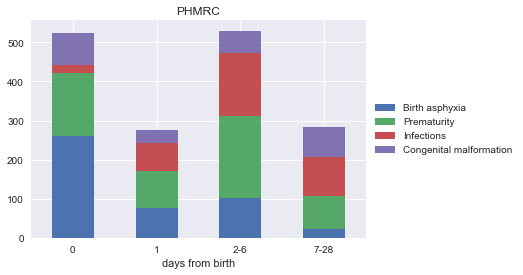

In [86]:
fig = plt.figure()
neonate_data.plot.bar(stacked=True, rot=0, ax=fig.gca(), title='PHMRC', legend='reverse')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Oxygen therapy during end of life
The very high proportion of VA interviews reporting respiratory symptoms in the PHMRC dataset is also worth noting. Table 3 shows rather non-specific relationships between respiratory symptoms and respiratory causes of death in the PHMRC data, which need further investigation and explanation. One possibility is that many patients in tertiary facilities may receive oxygen therapy in the final stages of an illness leading to death, which may be interpreted as respiratory difficulties by family and friends when later responding to a VA interview.

In [87]:
adults = df.loc[df.module == 'Adult']

In [88]:
resp = ['a2_36', 'a2_40', 'a2_42']
hospital_care = ['a6_02_4', 'a6_02_6']

In [89]:
codebook.loc[resp + hospital_care]

,question,module,health_care_experience,coding
variable,,,,
a2_36,Did [name] have difficulty breathing?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a2_40,Did [name] have fast breathing?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a2_42,Did [name] wheeze?,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a6_02_4,Care sought - government hospital,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."
a6_02_6,Care sought - private hospital,Adult,0,"0 ""No"" 1 ""Yes"" 8 ""Refused to Answer"" 9 ""Don't ..."


In [90]:
adults.a6_01.value_counts()

Yes           7478
No             361
Don't Know       1
Name: a6_01, dtype: int64

In [91]:
adults.a6_02_4.value_counts()

Yes    6993
No      848
Name: a6_02_4, dtype: int64

In [92]:
adults.a6_02_6.value_counts()

No                   5973
Yes                  1866
Refused to Answer       2
Name: a6_02_6, dtype: int64

In [93]:
resp_symptoms = adults[resp].applymap(lambda x: True if x == 'Yes' else False).any(1)
resp_symptoms.name = 'resp'
resp_symptoms.sum()

5467

In [94]:
hosp = adults[hospital_care].applymap(lambda x: True if x == 'Yes' else False).any(1)
hosp.name = 'hosp'

In [95]:
pd.crosstab(resp_symptoms, hosp, margins=True)

hosp,False,True,All
resp,,,
False,481,1893,2374
True,219,5248,5467
All,700,7141,7841


## Injuries with unrelated symptoms
By extension, this and similar issues also raise questions of the validity of using tertiary facility deaths as the evidence base for VA methods. For example, since all the injury cases in the PHMRC data were hospitalized, clearly none of them could have been instantaneous or near-instantaneous fatalities. On closer examination, many of the VAs for injury cases also reported a range of symptoms not obviously associated with their injuries by the time they died in hospital; but, according to the PHMRC protocols, any ‘third-party written account’ of an injury makes that injury the cause of death, irrespective of further clinical details [7].

In [96]:
yesno = codebook.loc[codebook.index.str.startswith('a2_') &
                     (codebook.coding == '0 "No" 1 "Yes" 8 "Refused to Answer" 9 "Don\'t Know"')]

In [97]:
injury_causes = [
    'Fires',
    'Drowning',
    'Falls',
    'Road Traffic',
    'Bite of Venomous Animal',
    'Suicide',
    'Other Injuries',
    'Homicide',
    'Poisonings',
    'Violent Death',
]
inj = df.loc[(df.module == 'Adult') & df.gs_text34.isin(injury_causes)]

In [98]:
inj_yesno = inj.loc[:, yesno.index].applymap(lambda x: True if x == 'Yes' else False)

In [99]:
inj_endorsement = pd.concat([codebook.loc[yesno.index, 'question'], inj_yesno.mean()], axis=1)
inj_endorsement.columns = ['question', 'All Injuries']
inj_endorsement = inj_endorsement.sort_values('All Injuries', ascending=False)
inj_endorse_by_cause = inj_yesno.groupby(inj.gs_text34).mean().T
inj_endorse = pd.concat([inj_endorsement, inj_endorse_by_cause], axis=1)
inj_endorse.sort_values('All Injuries', ascending=False).iloc[:20].to_csv('inj_endorse.csv')
inj_endorse.sort_values('All Injuries', ascending=False).iloc[:20]

,question,All Injuries,Bite of Venomous Animal,Drowning,Falls,Fires,Homicide,Other Injuries,Poisonings,Road Traffic,Suicide
a2_36,Did [name] have difficulty breathing?,0.396867,0.606061,0.018868,0.456647,0.344262,0.508982,0.223301,0.500000,0.465347,0.387097
a2_74,Did [name] experience a period of loss of cons...,0.352480,0.515152,0.037736,0.456647,0.213115,0.431138,0.213592,0.430233,0.500000,0.241935
a2_77,Did it continue until death?,0.295039,0.469697,0.028302,0.358382,0.139344,0.383234,0.174757,0.360465,0.450495,0.177419
a2_40,Did [name] have fast breathing?,0.208877,0.196970,0.018868,0.277457,0.196721,0.281437,0.087379,0.325581,0.217822,0.201613
a2_02,Did [name] have a fever?,0.188860,0.060606,0.028302,0.306358,0.229508,0.203593,0.087379,0.220930,0.267327,0.104839
a2_20,Did [name] look pale?,0.187119,0.030303,0.009434,0.196532,0.254098,0.239521,0.135922,0.232558,0.247525,0.185484
a2_49,Did [name] have a change in bowel habits?,0.154917,0.242424,0.018868,0.179191,0.254098,0.149701,0.029126,0.220930,0.143564,0.177419
a2_53,Did [name] vomit in the week preceding the death?,0.140992,0.212121,0.009434,0.179191,0.098361,0.083832,0.029126,0.488372,0.089109,0.217742
a2_25,Did [name] have puffiness of the face?,0.138381,0.227273,0.009434,0.156069,0.221311,0.161677,0.009709,0.162791,0.153465,0.129032
a2_18,Had [name] lost weight in the three months pri...,0.129678,0.015152,0.009434,0.208092,0.172131,0.095808,0.077670,0.255814,0.108911,0.177419


In [100]:
inj_endorse_by_cause = inj_yesno.groupby(inj.gs_text34).mean().loc[:, inj_endorsement.index[:10]].T
inj_endorse_by_cause

gs_text34,Bite of Venomous Animal,Drowning,Falls,Fires,Homicide,Other Injuries,Poisonings,Road Traffic,Suicide
variable,,,,,,,,,
a2_36,0.606061,0.018868,0.456647,0.344262,0.508982,0.223301,0.500000,0.465347,0.387097
a2_74,0.515152,0.037736,0.456647,0.213115,0.431138,0.213592,0.430233,0.500000,0.241935
a2_77,0.469697,0.028302,0.358382,0.139344,0.383234,0.174757,0.360465,0.450495,0.177419
a2_40,0.196970,0.018868,0.277457,0.196721,0.281437,0.087379,0.325581,0.217822,0.201613
a2_02,0.060606,0.028302,0.306358,0.229508,0.203593,0.087379,0.220930,0.267327,0.104839
a2_20,0.030303,0.009434,0.196532,0.254098,0.239521,0.135922,0.232558,0.247525,0.185484
a2_49,0.242424,0.018868,0.179191,0.254098,0.149701,0.029126,0.220930,0.143564,0.177419
a2_53,0.212121,0.009434,0.179191,0.098361,0.083832,0.029126,0.488372,0.089109,0.217742
a2_25,0.227273,0.009434,0.156069,0.221311,0.161677,0.009709,0.162791,0.153465,0.129032


## Inconsistencies between cause of death and symptoms
Unsurprisingly, there were cases within the PHMRC database which showed blatant inconsistencies between hospital cause of death and responses to some VA questions. The most obvious were the 147 cases recorded as stillbirths in hospital but which were described as neonatal deaths in VA interviews, and the 90 hospital maternal deaths described as neither pregnant nor recently delivered in VA interviews. There is no way of knowing from the dataset whether these reflected data quality issues either in the hospital causes of death or VA material, or whether VA respondents were actually, either knowingly or unwittingly, presenting a different picture.